## Install Detectron2

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-zrfo793f
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-zrfo793f
  Resolved https://github.com/facebookresearch/detectron2.git to commit 221448e4dcfbebf215b8d21ae7e4b1dfbf422d29


## Import Libraries

In [2]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt

from pycocotools.coco import COCO

# detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators

# Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

# Setup logger
setup_logger()

<Logger detectron2 (DEBUG)>

## Register dataset

In [3]:
Data_Resister_training="train_xworld";
Data_Resister_valid="val_xworld";
from detectron2.data.datasets import register_coco_instances

register_coco_instances(Data_Resister_training,{}, 'x_world/instances_train_xworld.json', Path("x_world/train_xworld"))
register_coco_instances(Data_Resister_valid,{},'x_world/instances_val_xworld.json', Path("x_world/val_xworld"))

metadata = MetadataCatalog.get(Data_Resister_training)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_valid = DatasetCatalog.get(Data_Resister_valid)

[04/08 15:01:28 d2.data.datasets.coco]: Loading x_world/instances_train_xworld.json takes 35.71 seconds.
[04/08 15:01:33 d2.data.datasets.coco]: Loaded 123719 images in COCO format from x_world/instances_train_xworld.json
[04/08 15:01:50 d2.data.datasets.coco]: Loading x_world/instances_val_xworld.json takes 2.06 seconds.
[04/08 15:01:50 d2.data.datasets.coco]: Loaded 5000 images in COCO format from x_world/instances_val_xworld.json


In [4]:
metadata

namespace(name='train_xworld',
          json_file='x_world/instances_train_xworld.json',
          image_root=PosixPath('x_world/train_xworld'),
          evaluator_type='coco',
          thing_classes=['nondisabledped',
                         'wheelchairped',
                         'visuallyimpairedped',
                         'rider',
                         'fourwheelveh',
                         'twowheelveh',
                         'wheelchair',
                         'cane'],
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7})

## Visualize some examples from training dataset

image name:x_world/train_xworld/000000061110.jpg
image name:x_world/train_xworld/000000001893.jpg
image name:x_world/train_xworld/000000056360.jpg


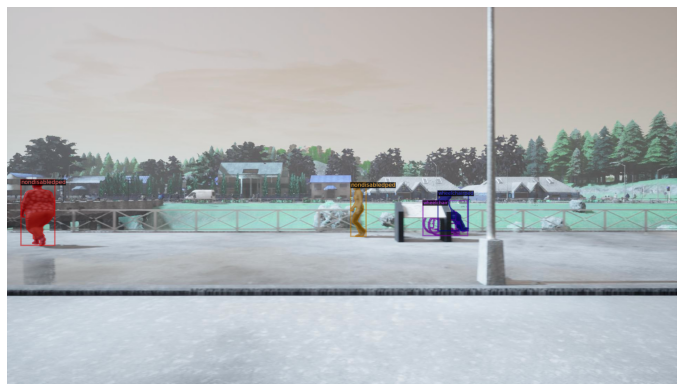

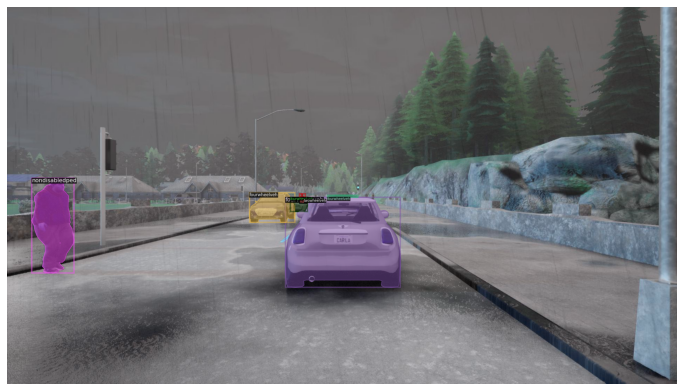

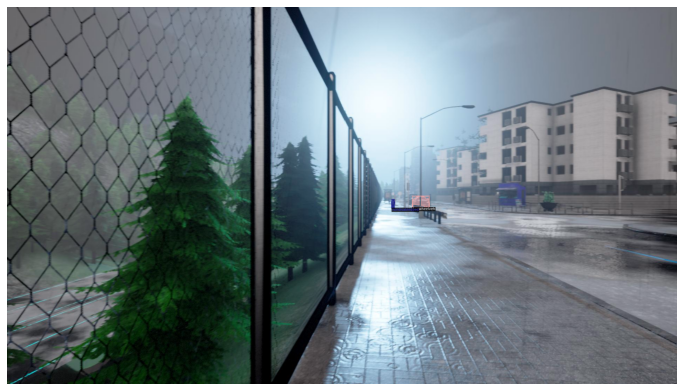

In [6]:
for i in random.sample(range(len(dataset_train)), k=3):
    sample = dataset_train[i]

    fig, ax = plt.subplots(figsize =(12,8))
    img = cv2.imread(sample["file_name"])
    v = Visualizer(
            img[:, :, ::-1],
            metadata=metadata, 
            instance_mode=ColorMode.IMAGE_BW
        )
    
    for s in sample["annotations"]:
        if 'keypoints' in s.keys():
            s.pop("keypoints", None)
            
    out = v.draw_dataset_dict(sample)
    ax.axis('off')
    print(f"image name:{sample['file_name']}")
    ax.imshow(out.get_image()[:, :, ::-1])

## Build evaluator

In [7]:
class Trainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return DatasetEvaluators([COCOEvaluator(dataset_name, output_dir=output_folder)])

## Customize Co

In [8]:
cfg = get_cfg()
config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml" 
cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)

cfg.MODEL.WEIGHTS ="detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x/137260431/model_final_a54504.pkl"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8 
cfg.MODEL.MASK_ON = True
cfg.MODEL.DEVICE = "cuda:0"


cfg.DATALOADER.NUM_WORKERS = 8

cfg.SOLVER.IMS_PER_BATCH = 8 
cfg.SOLVER.BASE_LR = 0.01 
cfg.SOLVER.WARMUP_ITERS = 10 
cfg.SOLVER.MAX_ITER = 2000 
cfg.SOLVER.STEPS = (500, 1000) 
cfg.SOLVER.CHECKPOINT_PERIOD=500

cfg.TEST.EVAL_PERIOD = 250

cfg.OUTPUT_DIR = "./output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

## Training

In [9]:
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/08 15:02:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[04/08 15:03:42 d2.data.datasets.coco]: Loading x_world/instances_train_xworld.json takes 44.10 seconds.
[04/08 15:03:43 d2.data.datasets.coco]: Loaded 123719 images in COCO format from x_world/instances_train_xworld.json
[04/08 15:03:53 d2.data.build]: Removed 0 images with no usable annotations. 123719 images left.
[04/08 15:03:56 d2.data.build]: Distribution of instances among all 8 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| nondisabled.. | 393771       | wheelchairped | 46752        | visuallyimp.. | 47648        |
|     rider     | 129944       | fourwheelveh  | 238728       |  twowheelveh  | 123108       |
|  wheelchair   | 47983        |     cane      | 39591        |               |              |
|     total     | 1067525      |               |              |               |              |
[04/08 15:03:56 d2.data.datas

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) 

[04/08 15:04:04 d2.engine.train_loop]: Starting training from iteration 0
[04/08 15:04:19 d2.utils.events]:  eta: 0:22:19  iter: 19  total_loss: 2.04  loss_cls: 0.5564  loss_box_reg: 0.4305  loss_mask: 0.508  loss_rpn_cls: 0.07228  loss_rpn_loc: 0.2543  time: 0.6812  data_time: 0.1023  lr: 0.01  max_mem: 0M
[04/08 15:04:32 d2.utils.events]:  eta: 0:21:49  iter: 39  total_loss: 1.273  loss_cls: 0.2933  loss_box_reg: 0.3445  loss_mask: 0.352  loss_rpn_cls: 0.05953  loss_rpn_loc: 0.1798  time: 0.6750  data_time: 0.0189  lr: 0.01  max_mem: 0M
[04/08 15:04:41 d2.engine.hooks]: Overall training speed: 50 iterations in 0:00:33 (0.6786 s / it)
[04/08 15:04:41 d2.engine.hooks]: Total training time: 0:00:33 (0:00:00 on hooks)
[04/08 15:04:41 d2.utils.events]:  eta: 0:21:42  iter: 52  total_loss: 1.188  loss_cls: 0.2541  loss_box_reg: 0.2441  loss_mask: 0.3259  loss_rpn_cls: 0.05218  loss_rpn_loc: 0.2325  time: 0.6725  data_time: 0.0198  lr: 0.01  max_mem: 0M


KeyboardInterrupt: 